# Stage 2: Full Pipeline with Linear Model

# 1. Preprocessing 

## 1.1 Loading the data

In [1]:
# Imports
import os
import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import shutil
from data.util import *
from data.util_dualclf import *
from data.transformer import * 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import AdaBoostClassifier

# load training and testing data into memory
root_path = "data3"
X_train, s_train_str, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()
X_test = TestDataLoader(root_path).load()
X_train, s_train_str, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()

# X_train: all features (pixels x 3) of all training samples (4146)
# s_train: superclasses of all samples (4146); note ordered
# y_train: classes of all samples (4146); note ordered
# p_train: pole IDs of all samples (4146)
# i_train: indices of all samples (4146); note duplicates
# X_test: all features (pixels x 3) of all testing samples (4293)

# Make sure that you properly encode the CLASSES such that 
# the order in your submission files is correct!
label_enc = LabelEncoder()
label_enc.fit(CLASSES)
y_train = label_enc.transform(y_train_str) # numerical labels

# superclasses to number
label_enc_s = LabelEncoder()
label_enc_s.fit(SUPERCLASSES)
s_train = label_enc_s.transform(s_train_str)


# Randomizer
numpy_seed = 0
python_seed = 0
np.random.seed(numpy_seed)
random.seed(python_seed)

# display some numbers
number_of_train_samples = len(X_train)
number_of_classes = len(np.unique(y_train))
number_of_test_samples = len(X_test)
print('number of training samples:', number_of_train_samples)
print('number of testing samples:', number_of_test_samples)
print('number of labels:', number_of_classes)

number of training samples: 4146
number of testing samples: 4293
number of labels: 81


In [2]:
X_train = np.array(X_train)
y_train = np.array(y_train)
p_train = np.array(p_train)
# Keep indices of samples of every superclass, so we know which samples need 
# to be trained for which of the 12 2nd level classifiers 
# eg 4 samples, of superclass a, b, b, a. 
# these indices will look like this: [[0,3], [1,2]] <- if SUPERCLASSES looks like [a, b]
X_superclass_train = []

n = 0
for s in SUPERCLASSES:       
    matched_idx = [i for i, superclass in enumerate(s_train_str) if superclass == s]
    X_superclass_train.append(matched_idx)

## 1. Superclass distribution

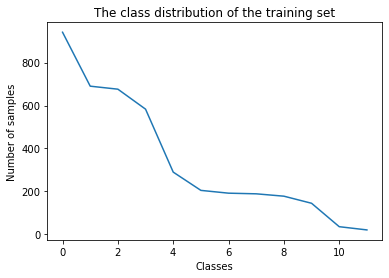

In [3]:
# Create a plot showing the class distribution in the training set
fig_distr, ax_distr = plt.subplots()
ax_distr.set_title("The class distribution of the training set")
ax_distr.set_xlabel("Classes")
ax_distr.set_ylabel("Number of samples")

count = countOcc(s_train)
plt.plot([i for i in range(len(count))], count);
fig_distr.savefig(os.path.join('visualization','superclass_distribution.png'))

# 4. Pipeline
Testing an estimator:
1. Fit: estimator.fit(X, y, groups=p_train)
2. Validate: cross_validate (copy from somewhere)
3. Show scores: show_scores()
4. Analysis: 
    * show missclassifications 
    * validation curve (hyperparameter tuning)
    * learning curve
    * kaggle score

## 4.1. Superclass Classifier

In [4]:
# cross validation strategy -- stratified and grouped
sc_cv_indices = []
folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
for train_fold, test_fold in sgkf:
    sc_cv_indices.append((train_fold, test_fold))

# different pipeline sections
pipeline_hog_rough = Pipeline([('resize', ResizeTransformer(size=32)),
                        ('hog', HogTransformer(resize=True))
                        ])
pipeline_colorhist = Pipeline([('colorhist', colorhistTransformer(nbin=4))])
pipeline_aspect_ratio = Pipeline([('aspect_ratio', AspectRatioTransformer())])

# combinated
union = FeatureUnion([('HOG', pipeline_hog_rough), 
                     ('COLOR', pipeline_colorhist),
                     ('REST', pipeline_aspect_ratio)
                     ])

scPipeline = Pipeline([('union', union),
                    ('scalar', StandardScaler()),
                    ('classify_lr', LogisticRegression(max_iter=1000, n_jobs=-2))
                    ])

# grid search
param_grid = {'classify_lr__C':[.1,1,2,5,10]} 

grid_search = GridSearchCV(scPipeline, param_grid=param_grid, cv=sc_cv_indices, 
                            scoring=neg_logloss_scorer, verbose=True, 
                            n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, s_train, groups=p_train)
show_grid_scores(grid_search)

# get best model and calculate score
scPipeline = get_best_model(grid_search)
scores = cross_validate(scPipeline, X_train, s_train, groups=p_train, 
                        cv=sc_cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished
Grid scores on training data set:
-0.064 (+/-0.032) for {'classify_lr__C': 0.1}
-0.063 (+/-0.043) for {'classify_lr__C': 1}
-0.065 (+/-0.046) for {'classify_lr__C': 2}
-0.067 (+/-0.051) for {'classify_lr__C': 5}
-0.069 (+/-0.055) for {'classify_lr__C': 10}
Best parameters set found on development set:  {'classify_lr__C': 1}

Obtained pipeline:
Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('HOG',
                                                 Pipeline(steps=[('resize',
                                                                  ResizeTransformer(size=32)),
                                                                 ('hog',
                                                                  HogTransformer(blockSize=32,
                          

## 4.2 Class Classifiers

First we try the exact same simple model for every class. But we will try to add a RFE to reduce complexity and the amount of components left can be dependent on the amount of classes the classifier has to distinguish. For example a classifier for the *blue_circles* has 7 classes, while *triangles* has 15 different classes, it follows that the complexity of the classifiers shouldn't be equal.

In [5]:
### INITIALIZE ALL 12 CLASSIFIERS
classPipelines = []
for i, s in enumerate(SUPERCLASSES):
    # print("Initializing the model for the class:", s)
    
    # break if superclass contains only one class
    if len(CLASSESFORSUPERCLASS[i]) == 1:
        continue

    # complexity should be dependent on # of different classes it has to distinguish
    complexity_level = len(CLASSESFORSUPERCLASS[i])

    # initialize different branches of the pipeline
    classPipeline_hog = Pipeline([('resize', ResizeTransformer(size=48)),
                                ('hog', HogTransformer(resize=True))
                                ]) # (48//8)**2 * 9 = 324 ftrs
    classPipeline_colorhist = Pipeline([('colorhist', colorhistTransformer(nbin=3))]) # 3**3 = 27 ftrs
    classPipeline_aspect_ratio = Pipeline([('aspect_ratio', AspectRatioTransformer())]) # 1 ftr

    # combinated
    classUnion = FeatureUnion([('HOG', classPipeline_hog), 
                            ('COLOR', classPipeline_colorhist),
                            ('REST', classPipeline_aspect_ratio)
                            ])

    classPipeline = Pipeline([('union', classUnion),
                            ('scalar', StandardScaler()),
                            ('classify_lr', LogisticRegression(max_iter=1000, n_jobs=-2))
                            ])

    classPipelines.append((s,classPipeline))
print("==== INITIALIZATION DONE ====")

==== INITIALIZATION DONE ====


In [6]:
### TRAIN ALL 12 CLASSIFIERS
from sklearn.model_selection import GroupKFold, StratifiedKFold

for i, (s, pipeline) in enumerate(classPipelines):
       
    print()
    print("Training the model for the class:", s)
    idx = X_superclass_train[SUPERCLASSES.index(s)]
    X = X_train[idx]
    y = y_train[idx]
    p = p_train[idx]
    
    # print(f'amount of groups: {len(np.unique(p))}')
    # print(f'total samples for this class: {len(X)}')
    
    cv_indices = []
    folds = 5
    
    sgkf = stratified_group_k_fold(X, y, p, k=folds)
    srkf = StratifiedKFold(n_splits=folds)
    for train_fold, test_fold in srkf.split(X, y):
        cv_indices.append((train_fold, test_fold))
        
        # print(f'train fold has {len(train_fold)} samples, while test has { len(test_fold)} samples in this fold.')


    # grid search
    param_grid = {'classify_lr__C':[.1]} 

    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv_indices, 
                                scoring=neg_logloss_scorer, verbose=True, 
                                n_jobs=-1, return_train_score=True)
    grid_search.fit(X, y, groups=p)
    show_grid_scores(grid_search)

    # get best model and calculate score
    classPipelines[i] = s, get_best_model(grid_search)
    scores = cross_validate(pipeline, X, y, groups=p, 
                            cv=cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
    show_scores(scores)

    print()
    print(f"==== DONE WITH MODEL {i+1} OF 12 ====")
    print()


elapsed:    4.5s finished
Grid scores on training data set:
-0.017 (+/-0.007) for {'classify_lr__C': 0.1}
Best parameters set found on development set:  {'classify_lr__C': 0.1}

Obtained pipeline:
Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('HOG',
                                                 Pipeline(steps=[('resize',
                                                                  ResizeTransformer(size=48)),
                                                                 ('hog',
                                                                  HogTransformer(blockSize=48,
                                                                                 blockStride=48,
                                                                                 cellSize=6,
                                                                                 resize=True,
                                                                                 winSize=48))])),


In [7]:
# Compare y_train with predict
predC = [pipeline.predict(X_train) for _, pipeline in classPipelines]
predSC = scPipeline.predict(X_train)
truePred = y_train

In [8]:
for i,y in enumerate(truePred):
    psc = predSC[i]
    # single class superclasses sc 2 and 23 corresponding with class 23 & 20
    if psc == 2:
        predC_i = 23
    elif psc == 10:
        predC_i = 20
    else:
        predC_i = predC[classPipelines.index(list(filter(lambda sp: sp[0] == s_train_str[i], classPipelines))[0])][i]
    Ccorrect = predC_i == y
    cl_str = label_enc.inverse_transform([y])[0]
    SCcorrect = cl_str in CLASSESFORSUPERCLASS[psc]
    if (Ccorrect and SCcorrect):
        continue
    
    print(f'{i:4d} - Correct: {"C" if Ccorrect else ""}{"S" if SCcorrect else ""} \t Wrong: {"" if Ccorrect else "C"}{"" if SCcorrect else "S"}')

# 5. Model Evaluation


In [ ]:
# Something about validation curve was here

## 5.2. Learning Curve

In [ ]:
# calculate and plot learning curve
learn_curv = learning_curve(scPipeline, X_train, s_train, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=sc_cv_indices, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=-2, shuffle=True)
plot_learning_curve(learn_curv)



In [ ]:
for i, (s, pipeline) in enumerate(classPipelines):
       
    print()
    print("Plotting learning curve for the class:", s)
    idx = X_superclass_train[SUPERCLASSES.index(s)]
    X = X_train[idx]
    y = y_train[idx]
    p = p_train[idx]
    
    # print(f'amount of groups: {len(np.unique(p))}')
    # print(f'total samples for this class: {len(X)}')
    
    cv_indices = []
    folds = 5
    
    sgkf = stratified_group_k_fold(X, y, p, k=folds)
    srkf = StratifiedKFold(n_splits=folds)
    for train_fold, test_fold in srkf.split(X, y):
        cv_indices.append((train_fold, test_fold))

    
    learn_curv = learning_curve(pipeline, X, y, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=cv_indices, groups=p, scoring=neg_logloss_scorer, 
                                    n_jobs=-2, shuffle=True)
    plot_learning_curve(learn_curv) 

## 5.3. Misclassifications

In [ ]:
# plot confusion matrix and corresponding misclassified images for a certain fold
# show_misclassifications(estimator, X_train, y_train, cv_indices, fold_number=1, N=20)

# 6. Submission

In [1]:
# Predict for all superclasses and combine them
probabilitiesPartial = []

for s, pipeline in classPipelines:
    proba = pipeline.predict_proba(X_test)
    probabilitiesPartial.append(proba)

    if s in ['squares', 'diamonds']:
        # Add proba for superclasses with only 1 class, which are forbidden and stop
        # 'forbidden' and 'stop' appear after resp. 'squares' and 'diamonds'
        shape = proba.shape[0], 1
        proba = np.ones(shape)
        probabilitiesPartial.append(proba)

NameError: name 'classPipelines' is not defined

In [ ]:
# Stack the probabilities to one big matrix 
probasClasses = []

for i, current_class in enumerate(CLASSES):
    # get which superclass it is
    current_superclass_i = SUPERCLASSES_v2[i]
    
    # which index in the superclass it is
    current_superclass_j = CLASSESFORSUPERCLASS[current_superclass_i].index(current_class)
    
    print(current_class, current_superclass_i, current_superclass_j)
    
    # get column probabilities for that class
    probaColumn = probabilitiesPartial[current_superclass_i][:,current_superclass_j]
    probasClasses = np.hstack((probasClasses, probaColumn))
    

In [ ]:
# Make big proba matrix for superclass Classifier
predict = scPipeline.predict_proba(X_test)

In [ ]:
# loop over probas of certain superclass
for i, probas in enumerate(predict.T):
    # Multiply column X amount of times (# classes in sc)
    repeats = len(CLASSESFORSUPERCLASS[i])
    probas = np.transpose([probas] * repeats)

    if i == 0:
        # declare array with column
        probasSupers = probas
    else:
        probasSupers = np.hstack((probasSupers, probas))

finalProb = np.multiply(probasSupers, probasClasses)

In [9]:
# train best model using all training data
# pipeline.fit(X_train, y_train) <-- Can't be done for dual clf

def customPredict_proba(test, classPipelines, scPipeline, X_test):
    # Predict for all superclasses and combine them
    probabilitiesPartial = []

    for s, pipeline in classPipelines:
        proba = pipeline.predict_proba(X_test)
        probabilitiesPartial.append(proba)
        
        if s in ['squares', 'diamonds']:
            # Add proba for superclasses with only 1 class, which are forbidden and stop
            # 'forbidden' and 'stop' appear after resp. 'squares' and 'diamonds'
            shape = proba.shape[0], 1
            proba = np.ones(shape)
            probabilitiesPartial.append(proba)

    # Stack the probabilities to one big matrix 
    
    probasClasses = probabilitiesPartial[0]

    for proba in probabilitiesPartial[1:]:
        probasClasses = np.hstack((probasClasses, proba))
    
    # Make big proba matrix for superclass Classifier
    predict = scPipeline.predict_proba(X_test)


    # loop over probas of certain superclass
    for i, probas in enumerate(predict.T):
        # Multiply column X amount of times (# classes in sc)
        repeats = len(CLASSESFORSUPERCLASS[i])
        probas = np.transpose([probas] * repeats)
        
        if i == 0:
            # declare array with column
            probasSupers = probas
        else:
            probasSupers = np.hstack((probasSupers, probas))

    return np.multiply(probasSupers, probasClasses)

# Here is where we create the submission for your estimator
output_probabilities = customPredict_proba(X_test, classPipelines, scPipeline, X_test)
create_submission(output_probabilities, 'submissionDual.csv')

In [ ]:
print(output_probabilities.shape)

for i, probabilities in enumerate(output_probabilities):
    if i % 50 == 0:
            
        chosenClass = probabilities.argmax()
        print(probabilities)
        c = label_enc.inverse_transform([chosenClass])[0]
        
        img = X_train[i]
        cv2.imshow(f'{c}', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        if i >200:
            break

    